# Random forest with Christman Field Data
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_christman.ipynb)

* Iris example adapted from: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* Further modified by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020
* Further adapted by: Prof. Elizabeth Barnes for ATS 655 and ATS 780A7 Spring 2022 at Colorado State University

Lets import some libraries we will need throughout this tutorial:



In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pydot
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150


In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"scikit-learn version = {sklearn.__version__}")  

python version = 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
numpy version = 1.21.5
scikit-learn version = 1.0.2


In [4]:
if(IN_COLAB==True):
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        local_path = '/content/drive/My Drive/Colab Notebooks/'
    except:
        local_path = './'
else:
    local_path = '../figures/'

In [5]:
FS = 16
plt.rc('text',usetex=False)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')


# 1. Data Preparation

### 1.1 Data overview

We have stored a .csv file on a CSU drive, accessible via URL. This will be the basis for our tutorial. This file contains Fort Collins weather data from 2020, and we will use these data to predict the high temperature for a given day with a random forest regression model.  

In [6]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/fccwx_data_2020.csv"
data = pd.read_csv(url,parse_dates=["Date"],infer_datetime_format=True)
data['dayofyear'] = data['Date'].dt.dayofyear
data.reindex(index=data.index[::-1])

,Date,Temp [C],RH [%],DewPt [C],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
8586,2020-01-01,-2.170,62.76,-8.315162,0.700,7,2.136,222,832.583,0.000,0.0,1
8585,2020-01-01,-2.304,59.01,-9.230945,1.295,191,3.724,191,831.717,0.000,0.0,1
8584,2020-01-01,-2.584,56.78,-9.984343,1.169,231,3.998,187,830.682,0.000,0.0,1
8583,2020-01-01,-3.807,67.52,-8.939013,0.744,145,3.567,260,829.882,0.028,0.0,1
8582,2020-01-01,-4.464,60.92,-10.869217,0.853,350,2.940,223,829.095,0.015,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-12-30,-7.118,78.45,-10.228470,0.534,279,1.333,264,0.000,0.017,0.0,365
3,2020-12-30,-8.140,81.80,-10.698280,0.385,54,1.392,230,0.000,0.017,0.0,365
2,2020-12-30,-10.010,80.40,-12.741851,0.404,106,1.803,328,825.593,0.068,0.0,365
1,2020-12-30,-9.990,76.70,-13.304007,0.591,8,2.156,336,830.078,0.040,0.0,365


Lets look at our data to see what we are working with

In [7]:
# Display first 5 rows
print('The shape of our features is:', data.shape)

The shape of our features is: (8587, 12)


In [8]:
# A handy tool in pandas: descriptive statistics for each column
data.describe()

,Temp [C],RH [%],DewPt [C],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
count,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000
mean,9.853770,51.615725,-1.660949,2.617602,202.304064,5.448292,205.797950,638.786884,174.151465,0.025527,182.166764
std,11.175732,24.028539,7.805753,2.241303,104.342626,4.109189,105.626903,358.531686,251.666787,0.227308,106.252753
min,-22.760000,4.516000,-24.897700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.959500,31.270000,-7.791443,1.174500,125.000000,2.920000,130.000000,787.782000,0.004000,0.000000,90.000000
50%,9.450000,50.030000,-2.201700,1.979000,196.000000,4.234000,213.000000,839.103000,8.520000,0.000000,179.000000
75%,18.355000,70.760000,4.480746,3.218000,302.000000,6.527000,306.000000,843.564000,302.350000,0.000000,276.000000
max,37.190000,99.600000,18.229760,18.880000,359.000000,123.800000,359.000000,1075.830000,993.000000,6.858000,365.000000


### 1.2 Targets and features

The pandas table is handy for a quick glance, but we need to organize some numpy arrays that separately contain our features and labels.

In [9]:
THRESHOLD_TEMP = 10   # default = 10
TARGET_VAR = 'Temp [C]'

# Labels are the values we want to predict
labels = (data[TARGET_VAR] > THRESHOLD_TEMP).astype(int) + (data[TARGET_VAR] > -THRESHOLD_TEMP/2).astype(int)
label_names = ('really cold <' + str(THRESHOLD_TEMP) + 'C', 'cold <' + str(THRESHOLD_TEMP) + 'C', 'warm >' + str(THRESHOLD_TEMP) + 'C')

# Remove the labels from the features
# axis 1 refers to the columns
features = data.drop(TARGET_VAR, axis = 1)

# Also remove DewPt and Date
features = features.drop('DewPt [C]', axis = 1)   # MODIFY: comment out if you want the prediction task to be easy
features = features.drop('Date', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features.describe()

,RH [%],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
count,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000
mean,51.615725,2.617602,202.304064,5.448292,205.797950,638.786884,174.151465,0.025527,182.166764
std,24.028539,2.241303,104.342626,4.109189,105.626903,358.531686,251.666787,0.227308,106.252753
min,4.516000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,31.270000,1.174500,125.000000,2.920000,130.000000,787.782000,0.004000,0.000000,90.000000
50%,50.030000,1.979000,196.000000,4.234000,213.000000,839.103000,8.520000,0.000000,179.000000
75%,70.760000,3.218000,302.000000,6.527000,306.000000,843.564000,302.350000,0.000000,276.000000
max,99.600000,18.880000,359.000000,123.800000,359.000000,1075.830000,993.000000,6.858000,365.000000


As a best practice for classification tasks, always look at a histograms of your labels prior to moving on.

In [10]:
# convert predictors to a numpy array
features = np.array(features)

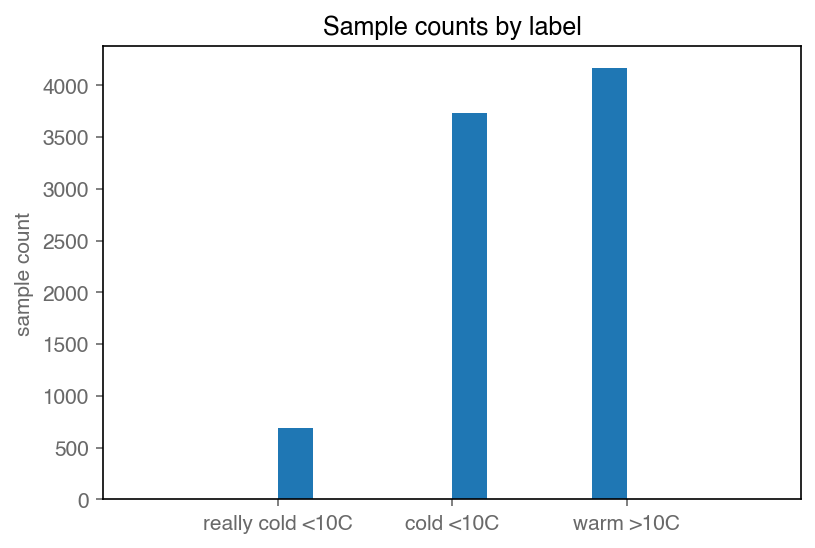

In [11]:
plt.figure()
plt.hist(labels)
plt.xticks(np.arange(0,len(label_names)),label_names)
plt.xlim(-1,3)
plt.title('Sample counts by label')
plt.ylabel('sample count')
plt.show()

### 1.3 Splitting training and testing datasets

Assuming we have no feature data available from 2019 we could use to test our trained models against, we will want to split up our dataset into training and testing portions. A standard proportion is 3/4 for training, 1/4 for testing, although this is somewhat arbitrary here. 

In [12]:
# Split the data into training and testing sets
split_size = 0.25  # MODIFY: proportion of the dataset we want to use for testing. 1 - split_size is used for training. 

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

Lets quickly check the size of our training and testing arrays are what we expect (and we didn't do something wrong)

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Validation Features Shape:', val_features.shape)
print('Validation Labels Shape:', val_labels.shape)

Training Features Shape: (6440, 9)
Training Labels Shape: (6440,)
Validation Features Shape: (2147, 9)
Validation Labels Shape: (2147,)


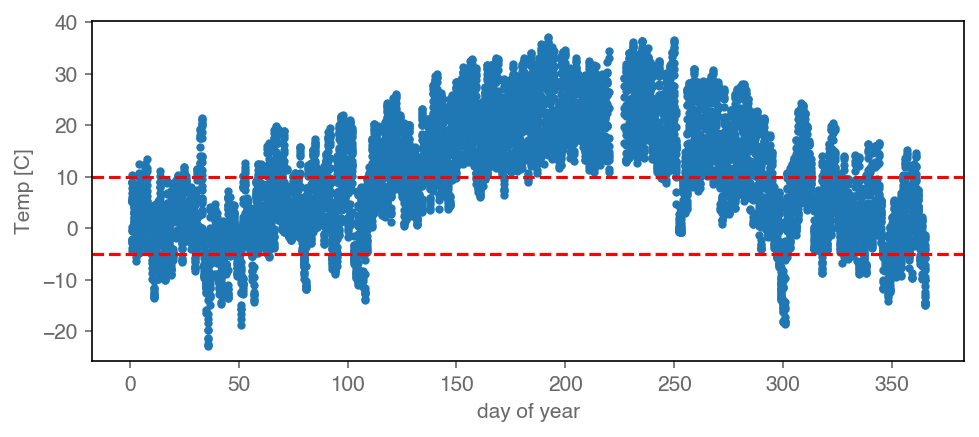

In [22]:
fig, ax1 = plt.subplots(figsize=(7.5,3))
plt.plot(features[:,-1],np.array(data[TARGET_VAR]),'.')
plt.axhline(y=THRESHOLD_TEMP,linestyle='--',color='r')
plt.axhline(y=-THRESHOLD_TEMP/2,linestyle='--',color='r')
plt.xlabel('day of year')
plt.ylabel(TARGET_VAR)
plt.show()

# 2. Creating a random forest

### Train the model and visualize it

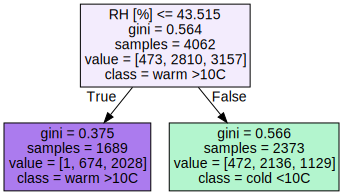

In [15]:
# RANDOM FOREST
tree_depth = 1       # MODIFY: how deep the tree is allowed to go 
node_split = 2       # MODIFY: minimum number of training samples needed to split a node
leaf_samples = 2     # MODIFY: minimum number of training samples required to make a leaf node
number_of_trees = 1  # MODIFY: number of trees to pool/average together in your random forest
criterion = 'gini'   # MODIFY: method for choosing impurity, can be "gini" or "entropy"
RAND_STATE = 42      # MODIFY: random number to split data up

tree_clf = RandomForestClassifier(n_estimators = number_of_trees, 
                           random_state = RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           criterion = criterion,
                           max_depth = tree_depth)
tree_clf.fit(train_features,train_labels)

#----------------------------------------------------------------------------------------------------
from graphviz import Source
fig_savename = 'tree_classifier_christman'

if(len(np.shape(tree_clf))!=0):
    tree_to_viz = tree_clf[0]       # MODIFY: which tree in your random forest do you want to plot, default is the first, i.e. [0]
else:
    tree_to_viz = tree_clf
export_graphviz(tree_to_viz,
                out_file=local_path + fig_savename+'.dot',
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=label_names,
                feature_names=feature_list)
Source.from_file(local_path + fig_savename+'.dot')

### Make predictions

In [16]:
# predict the class for each sample 
# result will be an integer for each prediction
y_pred_train = tree_clf.predict(train_features)
y_pred_val = tree_clf.predict(val_features)
y_pred_val

array([1, 2, 1, ..., 1, 2, 2])

In [17]:
# show the predicted proababilities for each class
# result will be a row for each class, and each row will
# have three columns denoting the Pr() for each type of iris
tree_clf.predict_proba(val_features)[:5]

array([[1.26304522e-01, 5.71581482e-01, 3.02113995e-01],
       [3.69959304e-04, 2.49352571e-01, 7.50277469e-01],
       [1.26304522e-01, 5.71581482e-01, 3.02113995e-01],
       [1.26304522e-01, 5.71581482e-01, 3.02113995e-01],
       [3.69959304e-04, 2.49352571e-01, 7.50277469e-01]])

### Visualization of predictions

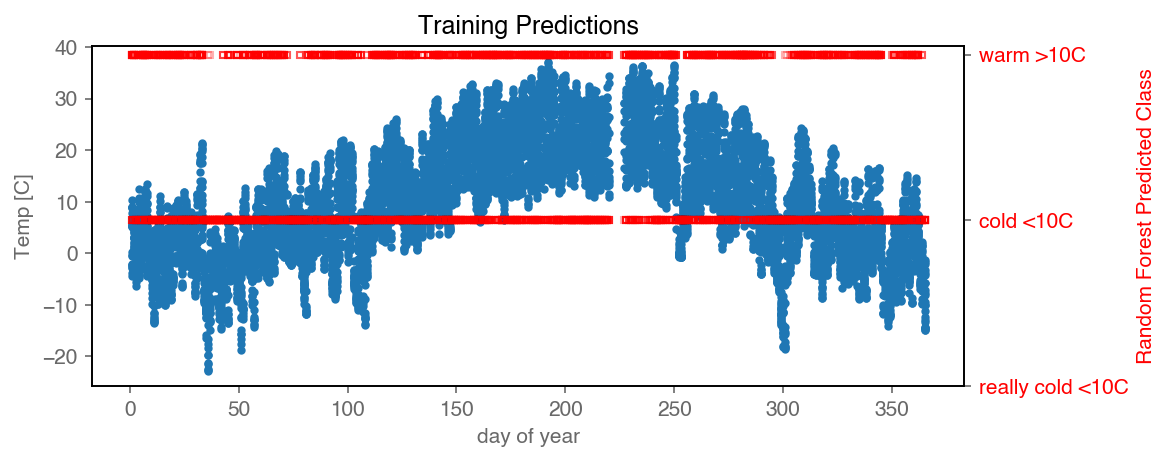

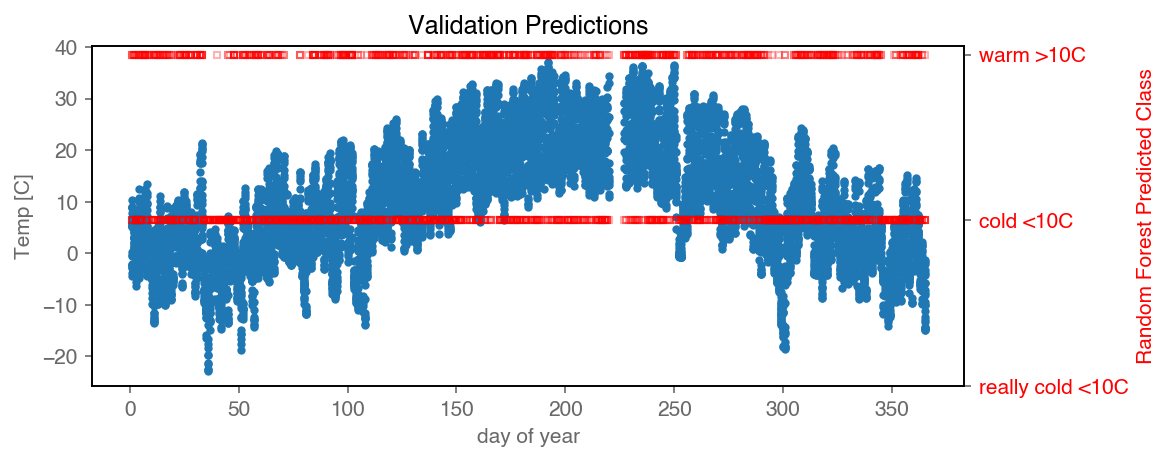

In [18]:
for split_type in ("Training","Validation"):
    
    if split_type=="Training":
        plot_features = train_features
        plot_pred = y_pred_train
    elif split_type=="Validation":
        plot_features = val_features
        plot_pred = y_pred_val        
    else:
        raise NotImplementedError()
    
    fig, ax1 = plt.subplots(figsize=(7.5,3))
    ax2 = ax1.twinx()

    ax1.plot(features[:,-1],np.array(data[TARGET_VAR]),'.')
    ax1.set_xlabel('day of year')
    ax1.set_ylabel(TARGET_VAR)

    ax2.plot(plot_features[:,-1],plot_pred,'s',markersize=3,alpha=.3,linewidth=.1,markeredgecolor='r',markerfacecolor='None',)
    ax2.set_yticks(np.arange(0,len(label_names)))
    ax2.set_yticklabels(label_names, color='r')
    ax2.set_ylabel('Random Forest Predicted Class',color='r')

    plt.title(split_type + ' Predictions')
    plt.show()

### Evaluate the classification predictions

Training confusion matrix
[[   0  506    2]
 [   0 2097  684]
 [   0 1146 2005]]


<Figure size 900x600 with 0 Axes>

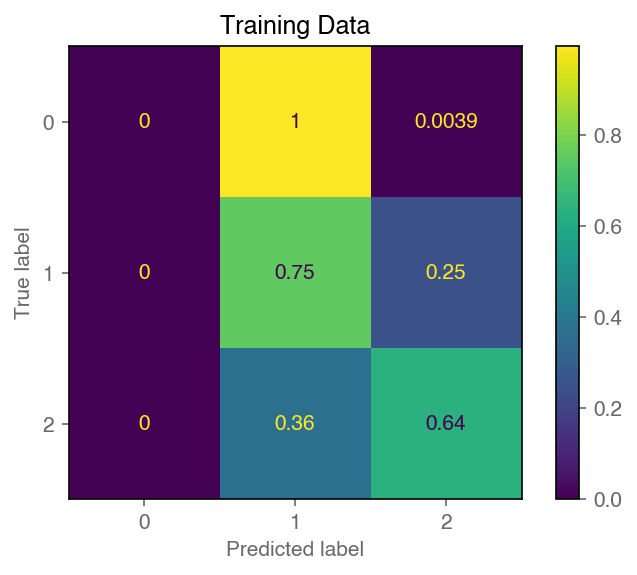

Validation confusion matrix
[[  0 177   1]
 [  0 687 264]
 [  0 388 630]]


<Figure size 900x600 with 0 Axes>

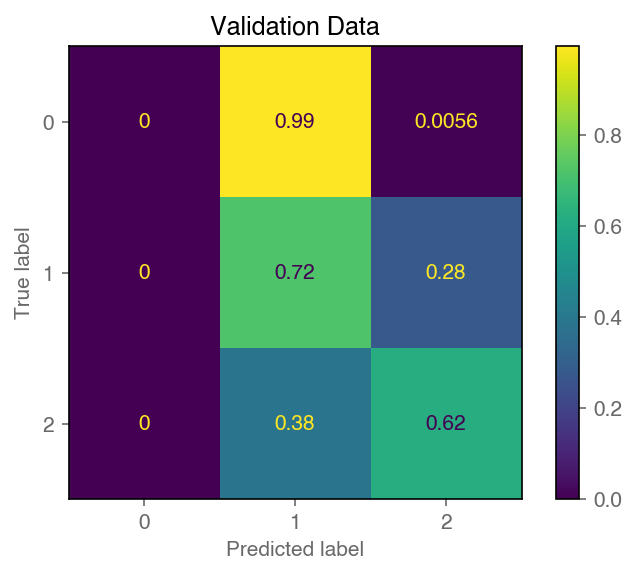

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for split_type in ("Training","Validation"):
    print(split_type + ' confusion matrix')    
    
    if split_type=="Training":
        plot_pred = tree_clf.predict(train_features)
        plot_labels = train_labels
    elif split_type=="Validation":
        plot_pred = tree_clf.predict(val_features)
        plot_labels = val_labels
    else:
        raise NotImplementedError()

    print(confusion_matrix(plot_labels, plot_pred))
    
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(plot_labels, plot_pred,normalize='true')
    plt.title(split_type + ' Data')
    plt.show()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print('ACCURACY')
print('    Training   = ' + str((accuracy_score(train_labels, y_pred_train)).round(3)))
print('    Validation = ' + str((accuracy_score(val_labels, y_pred_val)).round(3)))

print('')

print('Macro F1-Score')
print('    Training   = ' + str((f1_score(train_labels, y_pred_train, average='macro')).round(3)))
print('    Validation = ' + str((f1_score(val_labels, y_pred_val, average='macro')).round(3)))

print('')

print('Weighted F1-Score')
print('    Training   = ' + str((f1_score(train_labels, y_pred_train, average='weighted')).round(3)))
print('    Validation = ' + str((f1_score(val_labels, y_pred_val, average='weighted')).round(3)))


ACCURACY
    Training   = 0.637
    Validation = 0.613

Macro F1-Score
    Training   = 0.443
    Validation = 0.427

Weighted F1-Score
    Training   = 0.613
    Validation = 0.589


# EVALUATE YOUR MODEL ON 2021 TESTING DATA

In [21]:
raise ValueError('do not go below this line!')

ValueError: do not go below this line!

In [ ]:
# # # Read in data from url
# from sklearn.metrics import f1_score

# url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/fccwx_data_2021.csv"
# data = pd.read_csv(url,parse_dates=["Date"],infer_datetime_format=True)
# data['dayofyear'] = data['Date'].dt.dayofyear
# data.reindex(index=data.index[::-1])

# # Labels are the values we want to predict
# labels = (data[TARGET_VAR] > THRESHOLD_TEMP).astype(int) + (data[TARGET_VAR] > -THRESHOLD_TEMP/2).astype(int)

# # Remove the labels from the features
# # axis 1 refers to the columns
# features = data.drop(TARGET_VAR, axis = 1)

# # Also remove DewPt and Date
# features = features.drop('DewPt [C]', axis = 1)
# features = features.drop('Date', axis = 1)

# # Saving feature names for later use
# feature_list = list(features.columns)

# # Convert to numpy array
# features = np.array(features)

# # make the predictions
# y_pred_test = tree_clf.predict(features)

# # print the metrics report
# print(sklearn.metrics.classification_report(labels,y_pred_test))

# # print final f1 score
# print('---------------------------------------')
# print('Testing Macro F1-Score   : ' + str((f1_score(labels, y_pred_test,average='macro')).round(3)))
# print('Testing Weighted F1-Score: ' + str((f1_score(labels, y_pred_test,average='weighted')).round(3)))

# # print accuracies
# print('---------------------------------------')
# print('TRAINING ACCURACY  : ' + str((accuracy_score(train_labels, y_pred_train)).round(3)))
# print('VALIDATION ACCURACY: ' + str((accuracy_score(val_labels, y_pred_val)).round(3)))
# print('TESTING ACCURACY   : ' + str((accuracy_score(labels, y_pred_test)).round(3)))


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# ax1.plot(features[:,-1],np.array(data[TARGET_VAR]),'.')
# ax1.set_xlabel('day of year')
# ax1.set_ylabel(TARGET_VAR)

# ax2.plot(features[:,-1],y_pred_test,'s',markersize=3,alpha=.3,linewidth=.1,markeredgecolor='r',markerfacecolor='None',)
# ax2.set_yticks(np.arange(0,len(label_names)))
# ax2.set_yticklabels(label_names, color='r')
# ax2.set_ylabel('Random Forest Predicted Class',color='r')

# plt.title('Testing Predictions - 2021')
# plt.show()

# plt.figure()
# ConfusionMatrixDisplay.from_predictions(labels, y_pred_test, normalize='true')
# plt.title('Testing Data')
# plt.show()
